# Approach
As the suggested time taken in the exercise was 1.5h I realised I should work fast to get an end to end result. Hence I used several helper libraries just to demonstrate concepts of the data science workflow such as:
* EDA - pandas_profiling, seaborn
* Some hypothesis driven data eng - feature_tools and fast_ai
* Modelling / Testing - scikit_learn, fast_ai and shap

The focus was to get a good enough baseline and understanding so that I can formulate directions for future work.

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
%matplotlib inline  
sns.set(rc={'figure.figsize':(20,4)})
pd.set_option('display.max_columns', 50)

# EDA / Data Engineering

In [4]:
o_df = pd.read_csv("data/orders.csv")
r_df = pd.read_csv("data/restaurants.csv")

In [5]:
# profile = ProfileReport(r_df, title="Deliveroo Restaurant Report")
# profile.to_file("r_report.html")
# profile = ProfileReport(o_df, title="Deliveroo Orders Report")
# profile.to_file("o_report.html")

In [6]:
df = pd.merge(o_df, r_df, on = "restaurant_id", how = "inner", indicator=True).reset_index()
df._merge.value_counts()

both          32394
left_only         0
right_only        0
Name: _merge, dtype: int64

In [7]:
profile = ProfileReport(df, title="Deliveroo Restaurant Report")
profile.to_file("report.html")

Summarize dataset:   0%|          | 0/24 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
df["order_acknowledged_at_dt"] = pd.to_datetime(df.order_acknowledged_at)
df["order_acknowledged_at_dt_utc"] = pd.to_datetime(df.order_acknowledged_at, utc=True)
df["order_acknowledged_at_day"] = [dt.day for dt in df.order_acknowledged_at_dt]
df["order_acknowledged_at_hour"] = [dt.hour for dt in df.order_acknowledged_at_dt]
df["order_acknowledged_at_day_num"] = [dt.weekday() for dt in df.order_acknowledged_at_dt]

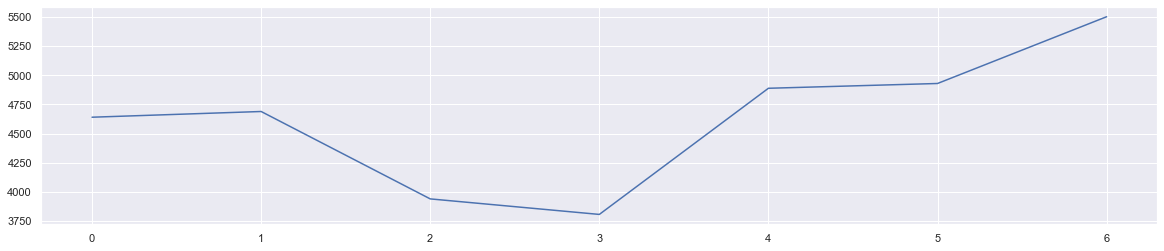

In [9]:
plt.plot(df.groupby("order_acknowledged_at_day_num").number_of_items.count()) # number of distinct order

<AxesSubplot:xlabel='order_acknowledged_at_day_num', ylabel='number_of_items'>

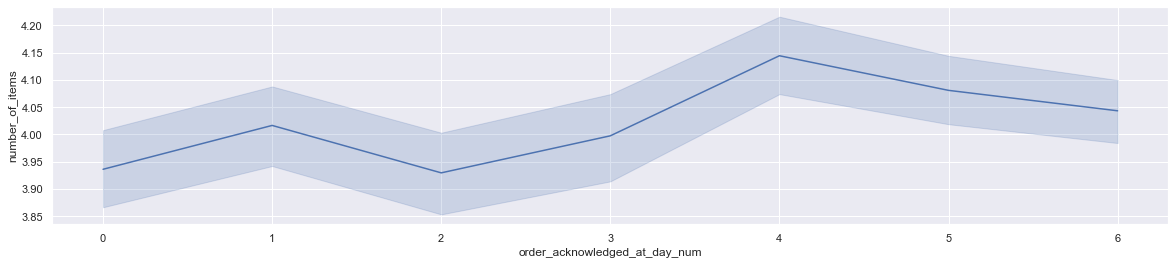

In [10]:
sns.lineplot(data=df, x="order_acknowledged_at_day_num", y="number_of_items")

<AxesSubplot:xlabel='order_acknowledged_at_day_num', ylabel='order_value_gbp'>

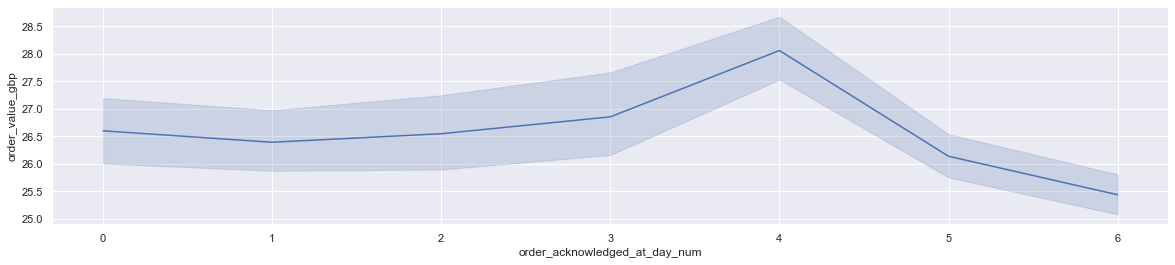

In [11]:
sns.lineplot(data=df, x="order_acknowledged_at_day_num", y="order_value_gbp")

<AxesSubplot:xlabel='order_acknowledged_at_day_num', ylabel='prep_time_seconds'>

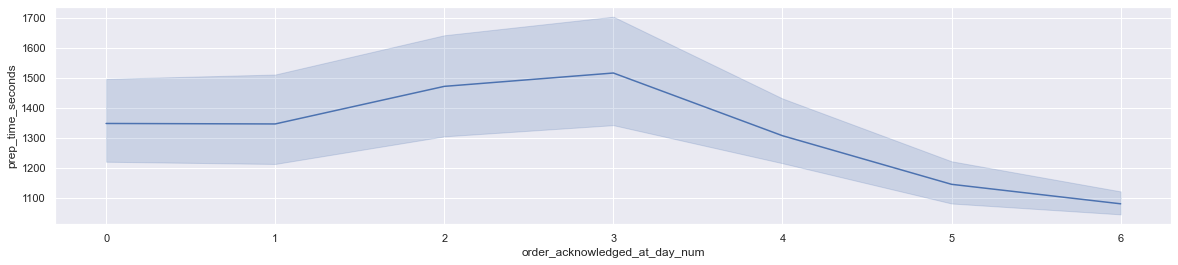

In [12]:
sns.lineplot(data=df, x="order_acknowledged_at_day_num", y="prep_time_seconds")

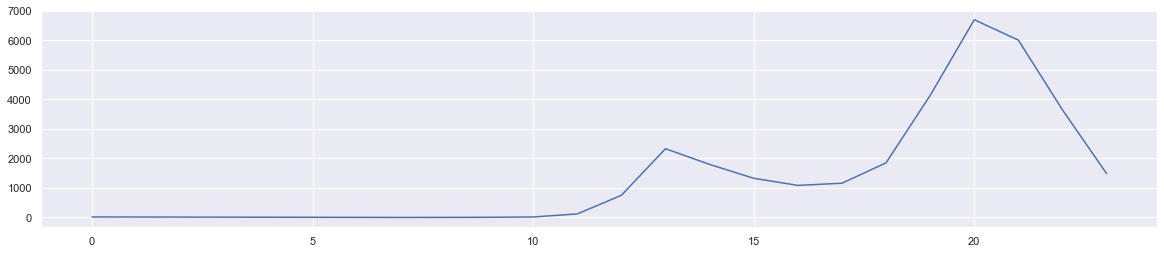

In [13]:
plt.plot(df.groupby("order_acknowledged_at_hour").number_of_items.count()) # number of distinct order

<AxesSubplot:xlabel='order_acknowledged_at_hour', ylabel='number_of_items'>

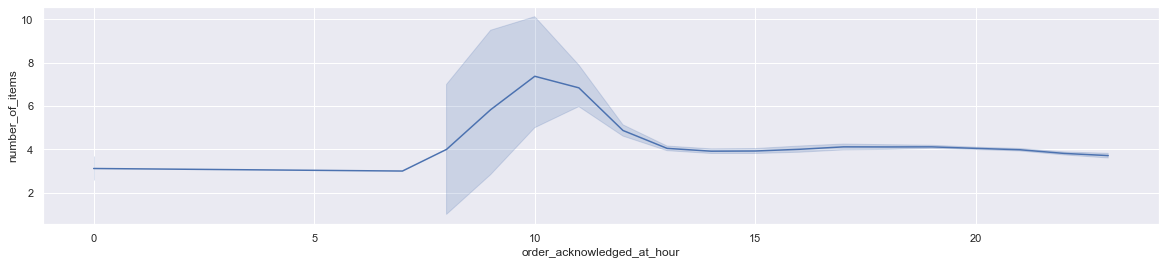

In [14]:
sns.lineplot(data=df, x="order_acknowledged_at_hour", y="number_of_items")

<AxesSubplot:xlabel='order_acknowledged_at_hour', ylabel='order_value_gbp'>

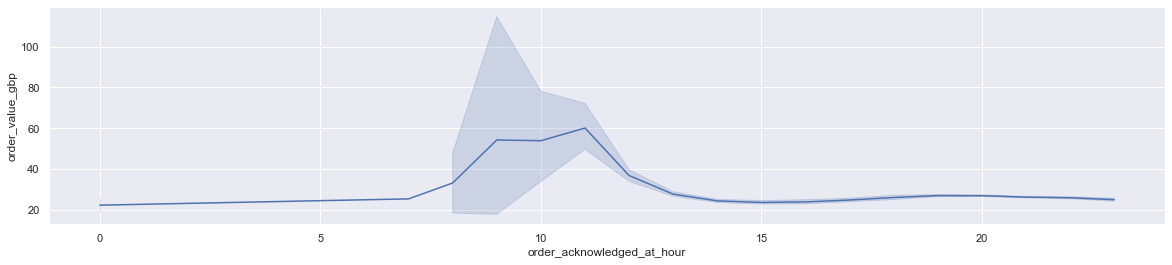

In [15]:
sns.lineplot(data=df, x="order_acknowledged_at_hour", y="order_value_gbp")

<AxesSubplot:xlabel='order_acknowledged_at_hour', ylabel='prep_time_seconds'>

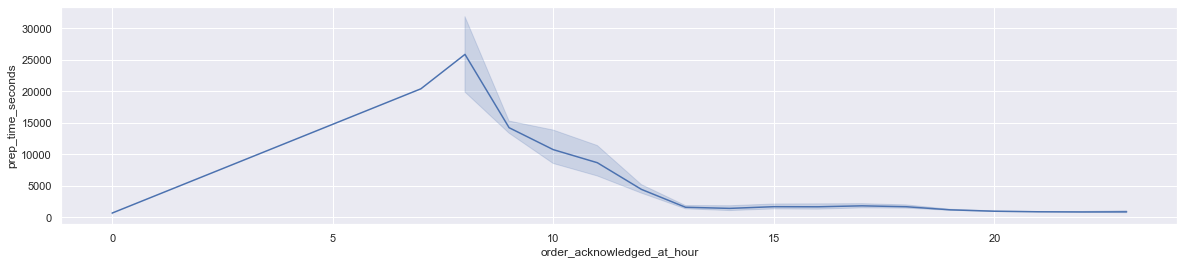

In [16]:
sns.lineplot(data=df, x="order_acknowledged_at_hour", y="prep_time_seconds")

<AxesSubplot:xlabel='order_acknowledged_at_hour', ylabel='prep_time_seconds'>

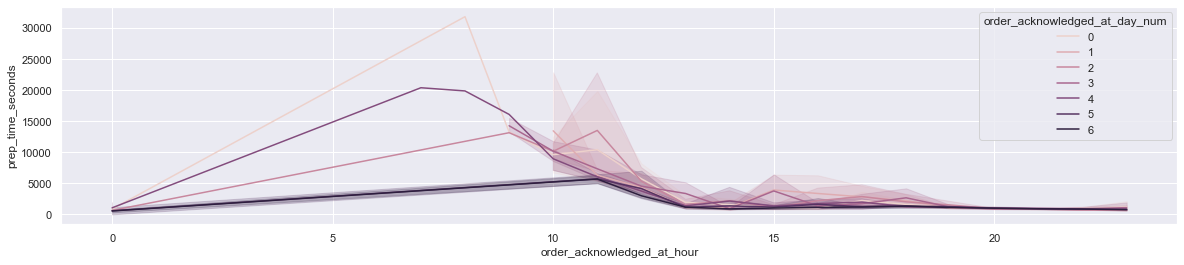

In [17]:
sns.lineplot(data=df, x="order_acknowledged_at_hour", y="prep_time_seconds", 
             hue="order_acknowledged_at_day_num", legend="brief")


**Findings from reports (report.html) and charts**
* Reports verify that data is clean, gives me information about the values and ranges. 
* From the report I don't see glaring problems from the dataset. 
* There are extreme values that could be removed to reduce noise, for example extreme large or low prep time values.
* There is some correlation between order_value and prep_time_seconds. Similar but with lesser scale is observed for number_of_items. This suggets a hypothesis that the larger the order the longer it takes to prepare.
* There are some time trends in the data. As expected over weekends (Fri-Sun) there are more orders yet the average prep time is lower than other days.
* During a day, prep time gradually decreases as we move into late lunch then to dinner shift. There are outliers for the period of 0-10 that could be cleaned from dataset.


## Feature engineering 
I applied featuretools and fastai helper functions to speed up feature engineering. Key hypothesis I wanted to test based on EDA and thinking about the problem are:
* Time of the day and day of the week influences prep time.
* Could the workload have an effect on prep time? E.g. amount of orders coming in before, size of current order

I applied featuretools first to quickly calculate aggregate features such as rolling mean, sum, time_since_last. The library ensures that I group by restaurants and take only historical data using order_acknowledged_at as cutoff time. Using featuretools and fastai I processed order_acknowledged_at to extract some time related features such as day of the week or hour etc. After that with fastai I filled missing values and normalised the features for later modelling. 

In [21]:
import featuretools as ft
from fastai.tabular.all import *

In [22]:
df.head()

df_index             order_acknowledged_at  \
0         0  2015-06-01 12:28:28.952789+01:00   
1         1  2015-06-06 17:06:24.434807+01:00   
2         2  2015-06-08 14:56:15.503204+01:00   
3         3  2015-06-12 15:12:20.497925+01:00   
4         4  2015-06-01 13:07:10.794050+01:00   

                     order_ready_at  order_value_gbp  restaurant_id  \
0  2015-06-01 14:12:09.474896+01:00            59.90           1326   
1  2015-06-06 17:16:27.520253+01:00            24.00           1326   
2  2015-06-08 15:03:39.397496+01:00            15.25           1326   
3  2015-06-12 15:23:30.064683+01:00            28.05           1326   
4  2015-06-01 14:02:25.104517+01:00            56.30            255   

   number_of_items  prep_time_seconds country    city type_of_food _merge  \
0                2               6220      UK  London     burritos   both   
1                8                603      UK  London     burritos   both   
2                3                443      UK  London     burritos   both   
3                8                669      UK  London     burritos   both   
4                7               3314      UK  London      chinese   both   

           order_acknowledged_at_dt     order_acknowledged_at_dt_utc  \
0  2015-06-01 12:28:28.952789+01:00 2015-06-01 11:28:28.952789+00:00   
1  2015-06-06 17:06:24.434807+01:00 2015-06-06 16:06:24.434807+00:00   
2  2015-06-08 14:56:15.503204+01:00 2015-06-08 13:56:15.503204+00:00   
3  2015-06-12 15:12:20.497925+01:00 2015-06-12 14:12:20.497925+00:00   
4  2015-06-01 13:07:10.794050+01:00 2015-06-01 12:07:10.794050+00:00   

   order_acknowledged_at_day  order_acknowledged_at_hour  \
0                          1                          12   
1                          6                          17   
2                          8                          14   
3                         12                          15   
4                          1                          13   

   order_acknowledged_at_day_num  
0                              0  
1                              5  
2                              0  
3                              4  
4                              0

In [23]:
o_df["order_acknowledged_at_notz"] = pd.to_datetime(o_df.order_acknowledged_at, utc=True).dt.tz_localize(None)
o_df["order_ready_at_notz"] = pd.to_datetime(o_df.order_ready_at, utc=True).dt.tz_localize(None)
o_df["order_acknowledged_at_dt_utc"] = pd.to_datetime(o_df.order_acknowledged_at, utc=True)
add_datepart(o_df, "order_acknowledged_at_dt_utc", drop=False) # fast ai time features
o_df = o_df.reset_index()
o_df.head().T

0  \
index                                                                        0   
order_acknowledged_at                         2015-06-01 12:28:28.952789+01:00   
order_ready_at                                2015-06-01 14:12:09.474896+01:00   
order_value_gbp                                                           59.9   
order_acknowledged_at_dt_utcWeek                                            23   
restaurant_id                                                             1326   
number_of_items                                                              2   
prep_time_seconds                                                         6220   
order_acknowledged_at_notz                          2015-06-01 11:28:28.952789   
order_ready_at_notz                                 2015-06-01 13:12:09.474896   
order_acknowledged_at_dt_utc                  2015-06-01 11:28:28.952789+00:00   
order_acknowledged_at_dt_utcYear                                          2015   
order_acknowledged_at_dt_utcMonth                                            6   
order_acknowledged_at_dt_utcDay                                              1   
order_acknowledged_at_dt_utcDayofweek                                        0   
order_acknowledged_at_dt_utcDayofyear                                      152   
order_acknowledged_at_dt_utcIs_month_end                                 False   
order_acknowledged_at_dt_utcIs_month_start                                True   
order_acknowledged_at_dt_utcIs_quarter_end                               False   
order_acknowledged_at_dt_utcIs_quarter_start                             False   
order_acknowledged_at_dt_utcIs_year_end                                  False   
order_acknowledged_at_dt_utcIs_year_start                                False   
order_acknowledged_at_dt_utcElapsed                                 1433158108   

                                                                             1  \
index                                                                        1   
order_acknowledged_at                         2015-06-06 17:06:24.434807+01:00   
order_ready_at                                2015-06-06 17:16:27.520253+01:00   
order_value_gbp                                                           24.0   
order_acknowledged_at_dt_utcWeek                                            23   
restaurant_id                                                             1326   
number_of_items                                                              8   
prep_time_seconds                                                          603   
order_acknowledged_at_notz                          2015-06-06 16:06:24.434807   
order_ready_at_notz                                 2015-06-06 16:16:27.520253   
order_acknowledged_at_dt_utc                  2015-06-06 16:06:24.434807+00:00   
order_acknowledged_at_dt_utcYear                                          2015   
order_acknowledged_at_dt_utcMonth                                            6   
order_acknowledged_at_dt_utcDay                                              6   
order_acknowledged_at_dt_utcDayofweek                                        5   
order_acknowledged_at_dt_utcDayofyear                                      157   
order_acknowledged_at_dt_utcIs_month_end                                 False   
order_acknowledged_at_dt_utcIs_month_start                               False   
order_acknowledged_at_dt_utcIs_quarter_end                               False   
order_acknowledged_at_dt_utcIs_quarter_start                             False   
order_acknowledged_at_dt_utcIs_year_end                                  False   
order_acknowledged_at_dt_utcIs_year_start                                False   
order_acknowledged_at_dt_utcElapsed                                 1433606784   

                                                                             2  \
index                                                    

In [24]:
es = ft.EntitySet(id="deliveroo_data")
es = es.entity_from_dataframe(
    entity_id="restaurant",
    dataframe=r_df,
    index="restaurant_id",
    variable_types={
        "country": ft.variable_types.Categorical,
        "city": ft.variable_types.Categorical,
        "type_of_food": ft.variable_types.Categorical,
    }
)

cols = ["index", "restaurant_id", "order_value_gbp", 
        "number_of_items", "prep_time_seconds", "order_acknowledged_at_notz", "order_ready_at_notz",
        "order_acknowledged_at_dt_utcDay", "order_acknowledged_at_dt_utcDayofweek", "order_acknowledged_at_dt_utcDayofyear",
        "order_acknowledged_at_dt_utcIs_month_end", "order_acknowledged_at_dt_utcIs_month_start"]
es = es.entity_from_dataframe(
    entity_id="orders",
    dataframe=o_df[cols],
    index="index",
    time_index="order_ready_at_notz",
    variable_types={
        "order_value_gbp": ft.variable_types.Numeric,
        "number_of_items": ft.variable_types.Numeric,
        "prep_time_seconds": ft.variable_types.Numeric,
        "order_acknowledged_at_notz": ft.variable_types.Datetime,
        "restaurant_id": ft.variable_types.Categorical,
        "order_acknowledged_at_dt_utcDay": ft.variable_types.Categorical,
        "order_acknowledged_at_dt_utcDayofweek": ft.variable_types.Categorical,
        "order_acknowledged_at_dt_utcDayofyear": ft.variable_types.Categorical,
        "order_acknowledged_at_dt_utcIs_month_end": ft.variable_types.Categorical,
        "order_acknowledged_at_dt_utcIs_month_start": ft.variable_types.Categorical
    }
)

new_relationship = ft.Relationship(
    es["restaurant"]["restaurant_id"],
    es["orders"]["restaurant_id"]
)
es = es.add_relationship(new_relationship)

In [25]:
cutoff_times = pd.DataFrame()
cutoff_times['index'] = o_df["index"]
cutoff_times["time"] = o_df["order_acknowledged_at_notz"]

In [26]:
# primitives = ft.primitives.list_primitives()
#primitives[primitives.type == "transform"]

In [46]:
import warnings
warnings.filterwarnings('ignore')
# run feature generation
feature_matrix, feature_defs = ft.dfs(
    entityset=es,
    target_entity="orders",
    agg_primitives=["count", "mean", "time_since_last", "sum", "last"],
    trans_primitives=["weekday", "hour"],
#     groupby_trans_primitives=["cum_count"],
    max_depth=2,
    cutoff_time=cutoff_times,
    cutoff_time_in_index=True,
    training_window="4 hour", # use 4 hour rolling historical window for aggregates
    approximate="30 minute" # round up our time index order_acknowledged_at to make processing faster
)

In [28]:
feature_defs

[<Feature: order_value_gbp>,
 <Feature: number_of_items>,
 <Feature: prep_time_seconds>,
 <Feature: restaurant_id>,
 <Feature: order_acknowledged_at_dt_utcDay>,
 <Feature: order_acknowledged_at_dt_utcDayofweek>,
 <Feature: order_acknowledged_at_dt_utcDayofyear>,
 <Feature: order_acknowledged_at_dt_utcIs_month_end>,
 <Feature: order_acknowledged_at_dt_utcIs_month_start>,
 <Feature: HOUR(order_acknowledged_at_notz)>,
 <Feature: HOUR(order_ready_at_notz)>,
 <Feature: WEEKDAY(order_acknowledged_at_notz)>,
 <Feature: WEEKDAY(order_ready_at_notz)>,
 <Feature: restaurant.country>,
 <Feature: restaurant.city>,
 <Feature: restaurant.type_of_food>,
 <Feature: restaurant.COUNT(orders)>,
 <Feature: restaurant.LAST(orders.index)>,
 <Feature: restaurant.LAST(orders.number_of_items)>,
 <Feature: restaurant.LAST(orders.order_acknowledged_at_dt_utcDay)>,
 <Feature: restaurant.LAST(orders.order_acknowledged_at_dt_utcDayofweek)>,
 <Feature: restaurant.LAST(orders.order_acknowledged_at_dt_utcDayofyear)>,


In [29]:
# inspect the features
feature_matrix.head().T

index                                                                                       0  \
time                                                               2015-06-01 11:28:28.952789   
order_value_gbp                                                                          59.9   
number_of_items                                                                             2   
prep_time_seconds                                                                        6220   
restaurant_id                                                                            1326   
order_acknowledged_at_dt_utcDay                                                             1   
order_acknowledged_at_dt_utcDayofweek                                                       0   
order_acknowledged_at_dt_utcDayofyear                                                     152   
order_acknowledged_at_dt_utcIs_month_end                                                False   
order_acknowledged_at_dt_utcIs_month_start                                               True   
HOUR(order_acknowledged_at_notz)                                                           11   
HOUR(order_ready_at_notz)                                                                  13   
WEEKDAY(order_acknowledged_at_notz)                                                         0   
WEEKDAY(order_ready_at_notz)                                                                0   
restaurant.country                                                                         UK   
restaurant.city                                                                        London   
restaurant.type_of_food                                                              burritos   
restaurant.COUNT(orders)                                                                  0.0   
restaurant.LAST(orders.index)                                                             NaN   
restaurant.LAST(orders.number_of_items)                                                   NaN   
restaurant.LAST(orders.order_acknowledged_at_dt_utcDay)                                   NaN   
restaurant.LAST(orders.order_acknowledged_at_dt_utcDayofweek)                             NaN   
restaurant.LAST(orders.order_acknowledged_at_dt_utcDayofyear)                             NaN   
restaurant.LAST(orders.order_acknowledged_at_dt_utcIs_month_end)                          NaN   
restaurant.LAST(orders.order_acknowledged_at_dt_utcIs_month_start)                        NaN   
restaurant.LAST(orders.order_value_gbp)                                                   NaN   
restaurant.LAST(orders.prep_time_seconds)                                                 NaN   
restaurant.MEAN(orders.number_of_items)                                                   NaN   
restaurant.MEAN(orders.order_value_gbp)                                                   NaN   
restaurant.MEAN(orders.prep_time_seconds)                                                 NaN   
restaurant.SUM(orders.number_of_items)                                                    0.0   
restaurant.SUM(orders.order_value_gbp)                                                    0.0   
restaurant.SUM(orders.prep_time_seconds)                                                  0.0   
restaurant.TIME_SINCE_LAST(orders.order_ready_at_notz)                                    NaN   

index                                                                                       1  \
time                                                               2015-06-06 16:06:24.434807   
order_value_gbp                                                                          24.0   
number_of_items                                                                             8   
prep_time_seconds                                                                         603   
restaurant_id                                                                            1326   
order_acknowledged_at_

# Modelling

I use GradientBoostingRegressor as an ensemble tree based model for regression problems. Ensemble methods tend to provide a good well rounded baseline and this model proves out to be a quite powerful one.

In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import shap
# load JS visualization code to notebook
shap.initjs()

In [31]:
feature_matrix_2 = feature_matrix.reset_index()

In [32]:
cat_names = ['restaurant.country', 'restaurant.city', 'restaurant.type_of_food', "order_acknowledged_at_dt_utcDay",
             "order_acknowledged_at_dt_utcDayofweek", "order_acknowledged_at_dt_utcDayofyear", "order_acknowledged_at_dt_utcIs_month_end",
             "order_acknowledged_at_dt_utcIs_month_start", "HOUR(order_acknowledged_at_notz)"]
cont_names = ['order_value_gbp', 'number_of_items', 'restaurant.MEAN(orders.order_value_gbp)', 'restaurant.COUNT(orders)', 
              "restaurant.LAST(orders.number_of_items)", "restaurant.LAST(orders.prep_time_seconds)", "restaurant.MEAN(orders.number_of_items)",
              'restaurant.MEAN(orders.prep_time_seconds)', "restaurant.SUM(orders.number_of_items)", "restaurant.SUM(orders.order_value_gbp)",
              "restaurant.SUM(orders.prep_time_seconds)", "restaurant.TIME_SINCE_LAST(orders.order_ready_at_notz)"]
procs = [Categorify, FillMissing]

# use random 20% as validation set, further specification could be applied so that we only use future data as validation 
# but this will be future work
splits = RandomSplitter(valid_pct=0.2)(range_of(feature_matrix_2))

In [33]:
dls = TabularDataLoaders.from_df(feature_matrix_2, procs=procs, cat_names=cat_names, cont_names=cont_names, 
                                 y_names="prep_time_seconds",
#                                  valid_idx=list(range(int(feature_matrix_2.shape[0]*0.8), feature_matrix_2.shape[0])),
                                 splits=splits,
                                 bs=128)
X_train, y_train = dls.train.xs, dls.train.ys.values.ravel()
X_test, y_test = dls.valid.xs, dls.valid.ys.values.ravel()

In [34]:
model = GradientBoostingRegressor(
    n_estimators=100, 
    learning_rate=0.1,
    max_depth=3,
    random_state=0,
    loss='ls'
)
model.fit(X_train, y_train)
print(mean_squared_error(y_test, model.predict(X_test)))
print(mean_absolute_error(y_test, model.predict(X_test)))

13640430.793794086
846.6391339150861


In [35]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

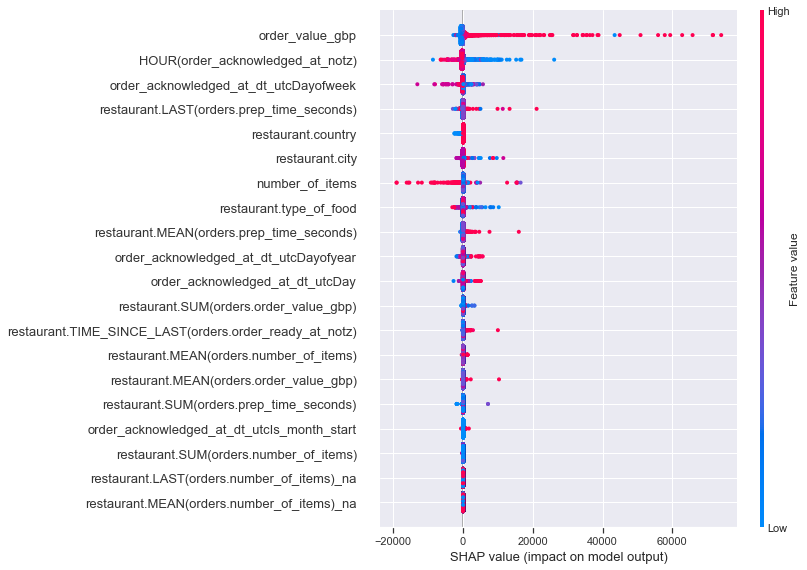

In [36]:
shap.summary_plot(shap_values, X_train)

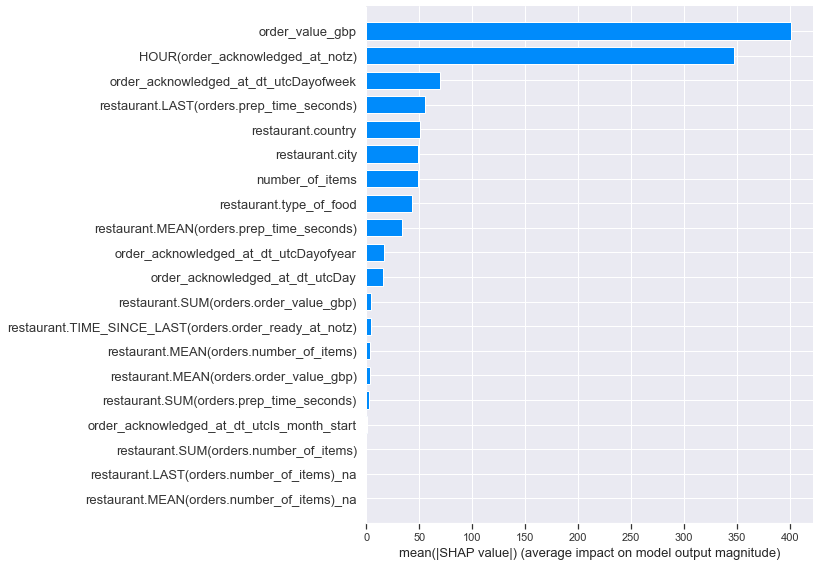

In [37]:
shap.summary_plot(shap_values, X_train, plot_type="bar")


The SHAP plot tells us about the developed model's importance and how it impacts the prediction. To simplify the model, I narrow down the variables I want to use in Fast AI modelling. From the charts I can for example interpret that as the order_value_gbp increases, the target variable prep_time_seconds increases as well. And this feature is one of the most important input to the model. I interpret other features as well and select them as variables to keep later on.

In [38]:
keep_cols = ["restaurant_id", "order_value_gbp", "number_of_items", "prep_time_seconds", 
             "restaurant.country", "restaurant.city", "restaurant.type_of_food", "index",
             "HOUR(order_acknowledged_at_notz)", "order_acknowledged_at_dt_utcDayofweek",
             "restaurant.LAST(orders.prep_time_seconds)", "restaurant.MEAN(orders.prep_time_seconds)"]

## Fast AI modelling
Using deep neural net and embedding layer we could gain further performance. The most advanced models nowadays tend to be neural nets and there is a powerful aspect of the embedding layer that can extract highly valuable information from categorical variables. Let's give it a try.

In [39]:
cat_names = ['restaurant.country', 'restaurant.city', 'restaurant.type_of_food',
             "order_acknowledged_at_dt_utcDayofweek", "HOUR(order_acknowledged_at_notz)"]
cont_names = ['order_value_gbp', 'number_of_items', "restaurant.LAST(orders.prep_time_seconds)",
              "restaurant.MEAN(orders.prep_time_seconds)"]
dls = TabularDataLoaders.from_df(feature_matrix_2[keep_cols], procs=procs, cat_names=cat_names, cont_names=cont_names, 
                                 y_names="prep_time_seconds",
#                                  valid_idx=list(range(int(feature_matrix_2.shape[0]*0.8), feature_matrix_2.shape[0])),
                                 splits=splits,
                                 bs=128)

In [40]:
# fix the range of possible prediction
print(o_df['prep_time_seconds'].quantile(.99))
max_y = 7634 * 1.2 #np.max(o_df['prep_time_seconds'])*1.2
y_range = torch.tensor([0, max_y])
y_range

7634.209999999999


tensor([   0.0000, 9160.7998])

In [41]:
# learn = tabular_learner(dls, layers=[1000,500], y_range=y_range, metrics=rmse)
learn = tabular_learner(dls, y_range=y_range, metrics=rmse)

In [42]:
learn.summary()

TabularModel (Input shape: 128 x torch.Size([128, 4]))
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 4             
Embedding                                 20         True      
____________________________________________________________________________
                     128 x 9             
Embedding                                 207        True      
____________________________________________________________________________
                     128 x 19            
Embedding                                 1596       True      
____________________________________________________________________________
                     128 x 5             
Embedding                                 40         True      
____________________________________________________________________________
                     128 x 8             
Embedding                                 152        True      
___________________________________________

SuggestedLRs(lr_min=0.003981071710586548, lr_steep=6.309573450380412e-07)

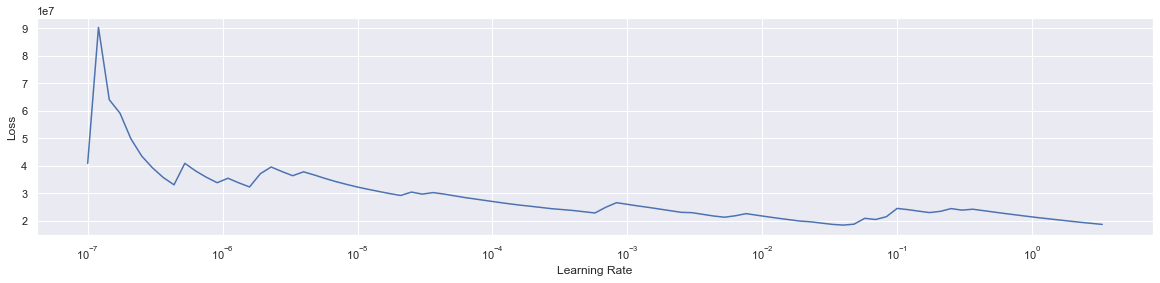

In [43]:
learn.lr_find()

In [44]:
learn.fit_one_cycle(10, 0.01)

In [45]:
y_pred = learn.get_preds(dl=dls.valid)
print(mean_squared_error(to_np(y_pred[0]), to_np(y_pred[1])))
print(mean_absolute_error(to_np(y_pred[0]), to_np(y_pred[1])))

11979680.567410026
772.9369454891095


# Summary
Through some helpers I quickly developed an end to end pipeline briefly touching on key points of ML worklow.

The final model from Fast AI yielded 885 MAE score meaning that on average the model was incorrect about preparation time by about 15 minutes. Not bad but certainly there is room for improvement.

In terms of business implications, the model could be used to give a ballpark measure to both the business, delivery person and customer in terms of when the food might arrive. Given the error rate perhaps it's not that reliable yet.

# Future work ideas

* More EDA and feature engineering would improve the model.
* Discard noise in the data such as extreme values
* Analyse generated feature interactions
* Using the baseline model investigate in which areas the model struggles and try to improve them.
* Use cross fold validation to test model robustness.
* Apply better train-test data split considering the time dimension the dataset
* With modelling we could use Bayesian methods to get a range estimate with confidence level which could be more useful to the drivers.
* We could turn the problem to be a categorical classification by binning the prep time into business meaningful values such as 'under 15 minutes', 'under 30 mins' or 'over an hour'.